<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

# 1) Model construction using Train set

## 1.1) Lybraries and functions

In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
from datetime import datetime

from sklearn import preprocessing
from sklearn import metrics 
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

#### SIDE NOTE
For the sack of conciseness, the all the preprocessing is arranged in the following function. And not much is changed from the original preprocessing, except for:
    
    1) Substitution of weekend for dayofweek feature (let the algorithm decide when it is best to partition).
    2) Creation of a new feature: loan duration.
    3) Labelling the loan_status as 0 (COLLECTION) and 1 (PAIDOFF).
    4) Only normalizing continuous features.
    5) Shuffling the dataset.

In [2]:
# INPUT: df directly converted from csv file
# OUTPUT: preprocessed features, already divided into X and y arrays, and an array of the selected features

def preprocessing_function(df):
    # Formatting
    df['due_date'] = pd.to_datetime(df['due_date'])
    df['effective_date'] = pd.to_datetime(df['effective_date'])

    # Feature Engineering
    df['dayofweek'] = df['effective_date'].dt.dayofweek
    df['loan_duration'] = (df['due_date'] - df['effective_date']).apply(lambda x: x.days)

    # Labelling and one hot coding
    df['Gender'].replace(to_replace = ['male','female'],value = [0,1], inplace = True)
    df['loan_status'].replace(to_replace = ['COLLECTION','PAIDOFF'], value = [0,1], inplace = True)
    df = pd.concat([df, pd.get_dummies(df['education'])], axis=1)
    df.drop(['Master or Above'], axis=1, inplace=True)

    # Normalize continuous data (labelled data is not)
    normalized_features = ['Principal','terms','age','loan_duration']
    df[normalized_features] = preprocessing.StandardScaler().fit_transform(df[normalized_features].astype(float))

    # Shuffle ALL rows, so that y is not perfectly ordered. It is important for K-fold latter on.
    df = df.sample(frac=1).reset_index(drop=True)

    # Final data
    features = ['Principal','terms','age','loan_duration','Gender','dayofweek','Bechalor','High School or Below','college']
    X = df[features].values
    y = df['loan_status'].values
    
    return X, y, features

In [3]:
# INPUT: dataframe containing the hyperparameter, the mean and std for train and test; and a option for log scale 
# OUTPUT: no return, only plots

def plotting_evaluation(df, log_scale = False):
    plt.figure(figsize = (10,5))
    ax = plt.subplot(111)
    ax.plot(df[df.columns[0]],
            df['mean_train_score'],
            color = 'b')
    ax.plot(df[df.columns[0]],
            df['mean_test_score'],
            color = 'g')
    ax.fill_between(df[df.columns[0]].astype('float64'),
                    df['mean_train_score'] - df['std_train_score'],
                    df['mean_train_score'] + df['std_train_score'],
                    alpha = 0.05,
                    color = 'b')
    ax.fill_between(df[df.columns[0]].astype('float64'),
                    df['mean_test_score'] - df['std_test_score'],
                    df['mean_test_score'] + df['std_test_score'],
                    alpha = 0.05,
                    color = 'g')
    ax.legend(loc = 'best')
    if log_scale == True: ax.set_xscale('log')
    plt.ylabel('F1-score')
    plt.xlabel(df.columns[0])
    plt.show()

## 1.2) Data loading and preprocessing

In [15]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

df = pd.read_csv('loan_train.csv')

X, y, features = preprocessing_function(df)

--2020-02-25 18:30:42--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2020-02-25 18:30:42 (11.9 MB/s) - ‘loan_train.csv’ saved [23101/23101]



#### SIDE NOTE

To counter the imbalance nature of this dataset, we use balanced class_weight hyperparameter (except for kNN, which does not have it) and f1 scoring metric.

We also use the GridSearchCV form sklearn, which provides an efficient K-fold cross-validation and hyperparameters tuning in a single method.

## 1.3) K Nearest Neighbor(KNN)

In [20]:
start_time = datetime.now() # -----------------------------------------------TIMING START-----------------

model = KNeighborsClassifier()
params_grid = {'n_neighbors': range(1, 26)}
grid = GridSearchCV(model, params_grid, cv = 5, scoring = 'f1')
grid.fit(X, y)

print('Runtime: ', datetime.now() - start_time) # ----------------------------TIMING END------------------

print('\nBEST PERFORMANCE')
print('Hyperparameters: ', grid.best_params_)
print('F1-score: ' + '{:.3}'.format(grid.best_score_))

kNN_model = grid.best_estimator_
print('\nFinal Model: ', kNN_model)

Runtime:  0:00:02.128535

BEST PERFORMANCE
Hyperparameters:  {'n_neighbors': 17}
F1-score: 0.842

Final Model:  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=17, p=2,
           weights='uniform')


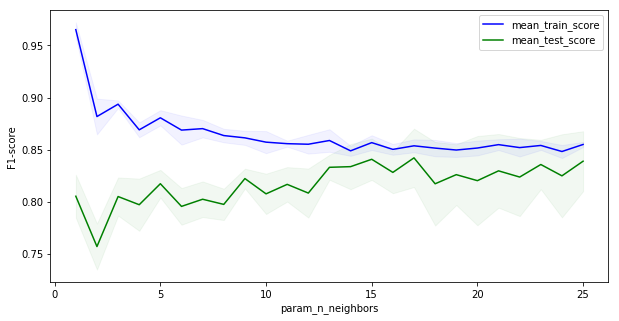

In [21]:
# Plotting for analysis
df_grid = pd.DataFrame(grid.cv_results_)
plotting_evaluation(df_grid[['param_n_neighbors', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']])

## 1.4) Decision Tree

In [146]:
start_time = datetime.now() # ------------------------------------------------------------------

model = DecisionTreeClassifier(criterion = 'gini', class_weight = 'balanced')
params_grid = {'max_depth': np.arange(1, 26, 1),
              'min_samples_leaf': np.arange(1, 11, 1)}
grid = GridSearchCV(model, params_grid, cv = 5, scoring = 'f1')
grid.fit(X, y)

print('Runtime: ', datetime.now() - start_time) # ----------------------------------------------

print('\nBEST PERFORMANCE')
print('Hyperparameters: ', grid.best_params_)
print('F1-score: ' + '{:.3}'.format(grid.best_score_))

tree_model = grid.best_estimator_
print('\nFinal Model: ', tree_model)

Runtime:  0:00:04.203188

BEST PERFORMANCE
Hyperparameters:  {'max_depth': 24, 'min_samples_leaf': 1}
F1-score: 0.796

Final Model:  DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=24, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


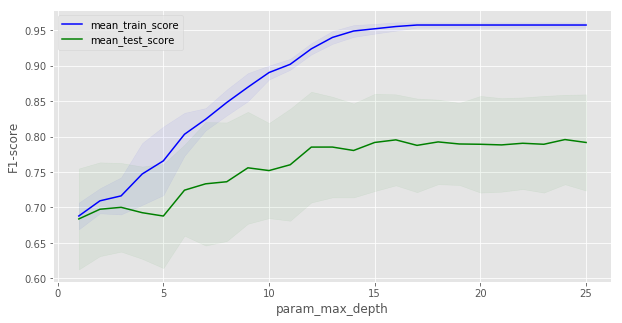

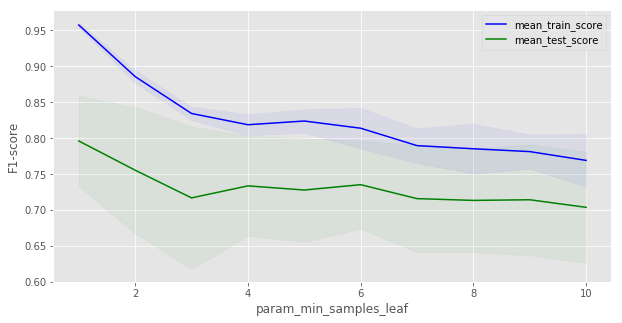

In [147]:
# INSPECTING HYPERPARAMETERS, VARYING ONLY ONE AT A TIME AND FIXING THE REST FOR THE BEST
df_grid = pd.DataFrame(grid.cv_results_)
plotting_evaluation(df_grid.loc[df_grid['param_min_samples_leaf'] == grid.best_params_['min_samples_leaf']][['param_max_depth', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']])
plotting_evaluation(df_grid.loc[df_grid['param_max_depth'] == grid.best_params_['max_depth']][['param_min_samples_leaf', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']])

In [131]:
!pip install pydotplus

     |████████████████████████████████| 286kB 6.3MB/s eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/35/7b/ab/66fb7b2ac1f6df87475b09dc48e707b6e0de80a6d8444e3628
Successfully built pydotplus


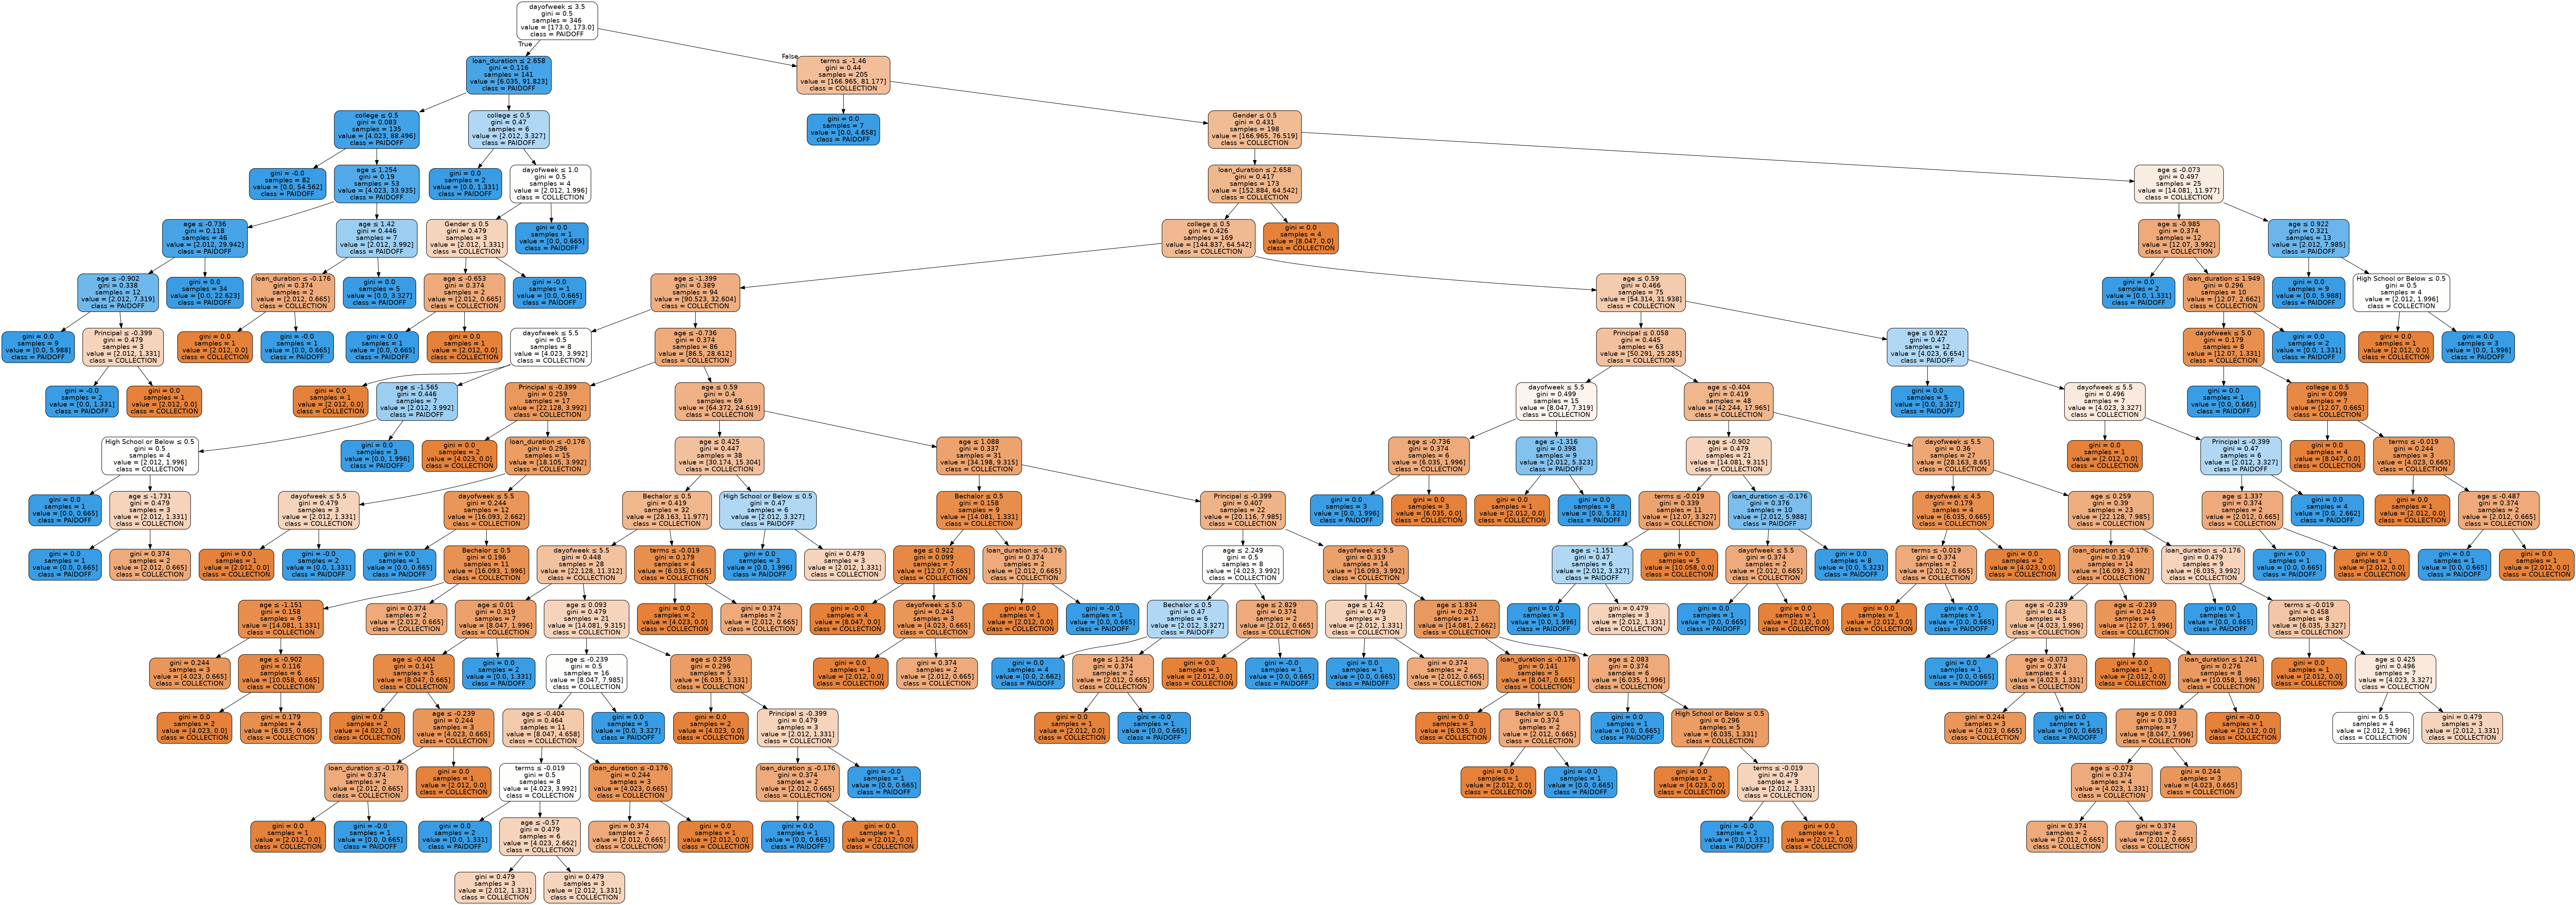

In [132]:
# Print the model
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image

dot_data = StringIO()

export_graphviz(tree_model,
                out_file = dot_data,
                feature_names = features,
                class_names = ['COLLECTION','PAIDOFF'],
                filled = True, rounded = True, special_characters = True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

Image(graph.create_png())

## 1.5) Support Vector Machine

In [151]:
start_time = datetime.now() # ------------------------------------------------------------------

model = svm.SVC(class_weight = 'balanced', gamma = 'auto')
params_grid = {'C': [0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000],
              'kernel': ['linear', 'rbf', 'sigmoid']}
grid = GridSearchCV(model, params_grid, cv = 5, scoring = 'f1')
grid.fit(X, y)

print('Runtime: ', datetime.now() - start_time) # ----------------------------------------------

print('\nBEST PERFORMANCE')
print('Hyperparameters: ', grid.best_params_)
print('F1-score: ' + '{:.3}'.format(grid.best_score_))

SVM_model = grid.best_estimator_
print('\nFinal Model: ', SVM_model)

Runtime:  0:05:00.263004

BEST PERFORMANCE
Hyperparameters:  {'C': 10000, 'kernel': 'rbf'}
F1-score: 0.779

Final Model:  SVC(C=10000, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


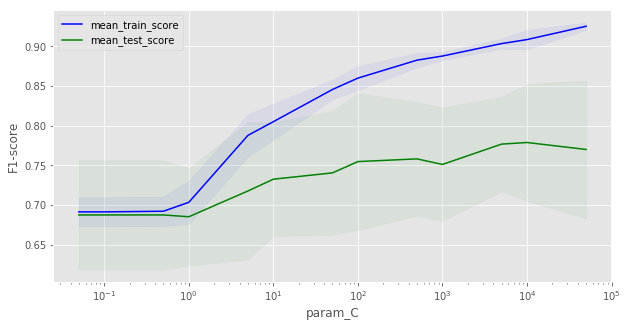

In [153]:
# INSPECTING HYPERPARAMETERS, VARYING ONLY ONE AT A TIME AND FIXING THE REST FOR THE BEST
df_grid = pd.DataFrame(grid.cv_results_)
plotting_evaluation(df_grid.loc[df_grid['param_kernel'] == grid.best_params_['kernel']][['param_C', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']], log_scale = True)
#plotting_evaluation(df_grid.loc[df_grid['param_C'] == grid.best_params_['C']][['param_kernel', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']])

## 1.6) Logistic Regression

In [138]:
start_time = datetime.now() # ------------------------------------------------------------------

model = LogisticRegression(class_weight = 'balanced', solver = 'lbfgs', penalty = 'l2')
params_grid = {'C': np.logspace(-3,3,13)}
grid = GridSearchCV(model, params_grid, cv = 5, scoring = 'f1')
grid.fit(X, y)

print('Runtime: ', datetime.now() - start_time) # ----------------------------------------------

print('\nBEST PERFORMANCE')
print('Hyperparameters: ', grid.best_params_)
print('F1-score: ' + '{:.3}'.format(grid.best_score_))

LR_model = grid.best_estimator_
print('\nFinal Model: ', LR_model)

Runtime:  0:00:00.858439

BEST PERFORMANCE
Hyperparameters:  {'C': 1.0}
F1-score: 0.712

Final Model:  LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)


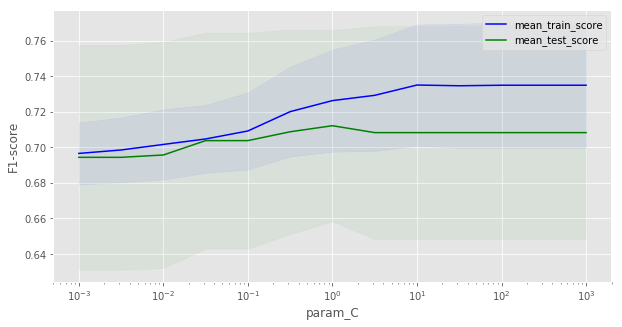

In [143]:
df_grid = pd.DataFrame(grid.cv_results_)
plotting_evaluation(df_grid[['param_C', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']], log_scale = True)

# 2) Model Evaluation using Test set

## 2.1) Lybraries and functions

In [103]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

from sklearn.metrics import confusion_matrix
import seaborn as sns

In [154]:
def evaluation(model, y, X):
    print('Jaccard: ' + '{:.3}'.format(jaccard_similarity_score(y, model.predict(X))))
    print('F1-score: ' + '{:.3}'.format(f1_score(y, model.predict(X))))
    print('LogLoss: ' + '{:.3}'.format(log_loss(y, model.predict(X))))

In [155]:
def confusion_matrix_plot(model, y, X):
    labels = [0, 1]
    cm = confusion_matrix(y, model.predict(X), labels = labels)
    plt.figure(figsize = (8,6))
    ax = sns.heatmap( pd.DataFrame(cm, labels, labels),
                      annot = True,
                      cmap = 'Blues'
                    )
    plt.style.use('ggplot')
    ax.set_ylim(len(cm), 0)
    # plt.title('Confusion Matrix', fontsize = 18)
    plt.xlabel('Predicted', fontsize = 16)
    plt.ylabel('Truth', fontsize = 16)
    plt.tick_params(labelsize= 10)
    plt.show()

## 2.2) Data loading and preprocessing

In [156]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

test_df = pd.read_csv('loan_test.csv')

test_X, test_y, features = preprocessing_function(test_df)

--2020-02-25 16:06:52--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-02-25 16:06:52 (254 MB/s) - ‘loan_test.csv’ saved [3642/3642]



## 2.3) ALL SCORES

k NEAREST NEIGHBORS
Jaccard: 0.759
F1-score: 0.854
LogLoss: 8.32


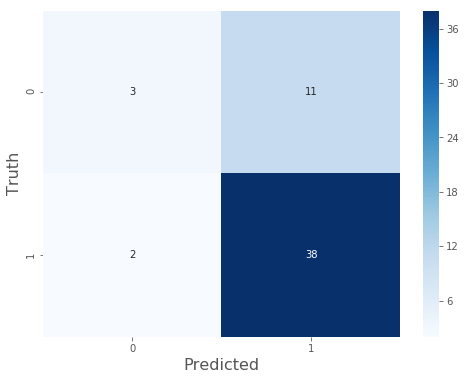


DECISION TREE
Jaccard: 0.63
F1-score: 0.744
LogLoss: 12.8


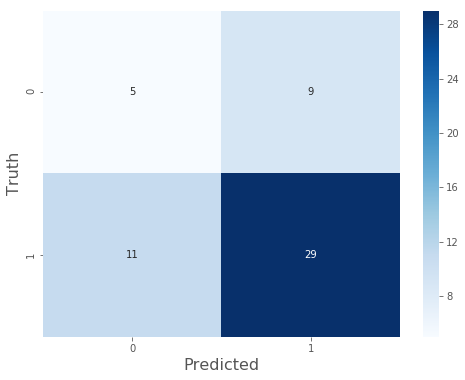


SUPPORT VECTOR MACHINE
Jaccard: 0.685
F1-score: 0.779
LogLoss: 10.9


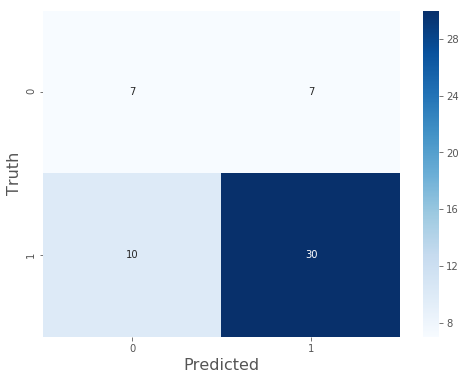


LOGISTIC REGRESSION
Jaccard: 0.593
F1-score: 0.676
LogLoss: 14.1


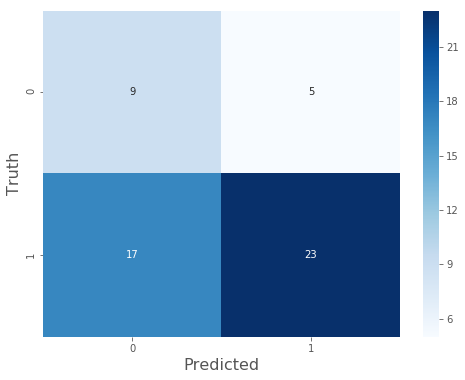

In [157]:
print('k NEAREST NEIGHBORS')
evaluation(kNN_model, test_y, test_X)
confusion_matrix_plot(kNN_model, test_y, test_X)

print('\nDECISION TREE')
evaluation(tree_model, test_y, test_X)
confusion_matrix_plot(tree_model, test_y, test_X)

print('\nSUPPORT VECTOR MACHINE')
evaluation(SVM_model, test_y, test_X)
confusion_matrix_plot(SVM_model, test_y, test_X)

print('\nLOGISTIC REGRESSION')
evaluation(LR_model, test_y, test_X)
confusion_matrix_plot(LR_model, test_y, test_X)

# 3) Report

#### FINAL NOTE

The fact that it is an imbalanced dataset can be very misleading, because the model can easily learn to predict only the majority class, leading to what seems to be a good accuracy of 75.14%, but it is actually the proportion between minority and majority classes. That is why confusion matrixes are plotted to verify that. We can see F1 is the most appropriate for imbalanced data. Yet, the model that best performes on predicting the minority class, had the worst performance on the 3 chosen scores.

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.759       | 0.854        | 8.32      |
| Decision Tree      | 0.63       | 0.744        | 12.8     |
| SVM                | 0.685       | 0.779        | 10.9      |
| LogisticRegression | 0.593       | 0.676        | 14.1       |